# Importing required modules

In [22]:
import os
from symfit import variables, Parameter, ODEModel, D, Fit, parameters, Variable
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path as pt
from ipywidgets.widgets import HBox, VBox, FloatLogSlider, BoundedIntText, interactive_output, BoundedFloatText, Text

%matplotlib inline

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from timescan import timescanplot
from time import time as start_time
os.getcwd()

'D:\\FELion_GUI2.1\\testing'

# Getting file and timescan data

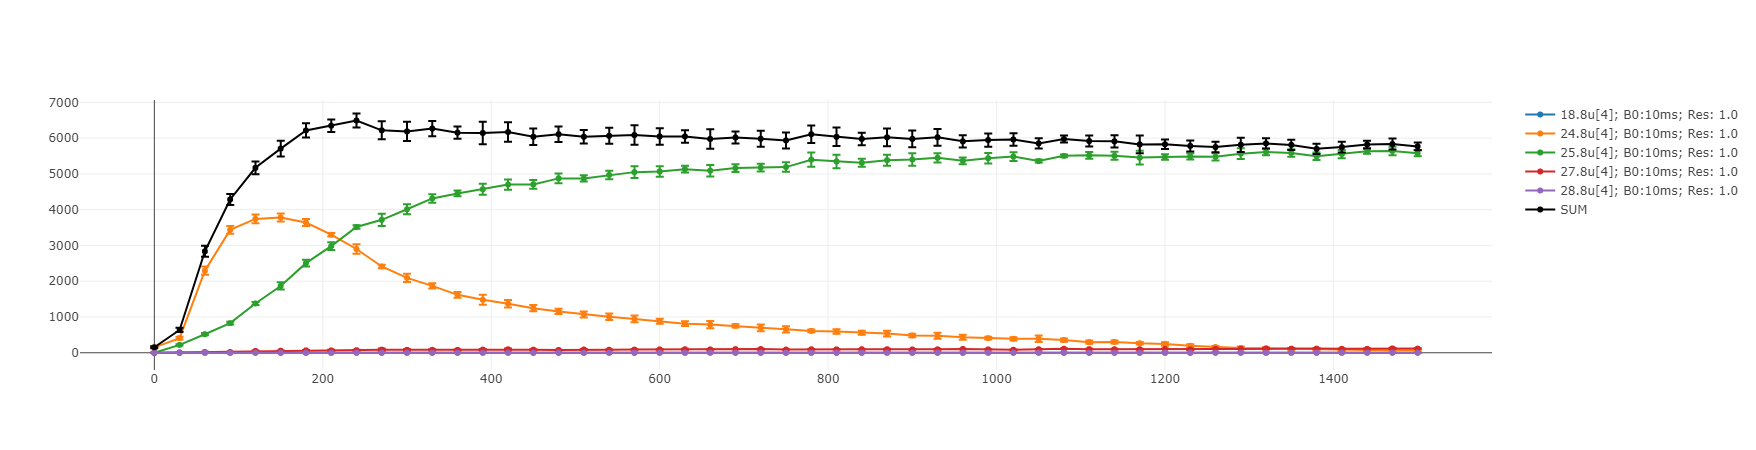

In [24]:
file = pt('./07_03_19-5.scan')

location = os.getcwd()
time, mean, error, mass, t_res, t_b0  = timescanplot(file).get_data()
m = timescanplot(file).get_fullmass()

data = list(m.values())
iplot(data)

In [15]:
timeStartIndex = 5
print(f'timeStartIndex: {timeStartIndex}')

timeStartIndex: 5


In [27]:
c2h = m['24.8u']['y'][timeStartIndex:]
c2h2 = m['25.8u']['y'][timeStartIndex:]
c2h4 = m['27.8u']['y'][timeStartIndex:]

new_time = time[timeStartIndex:]/1000

# Kinetic Model

In [17]:
C2H, C2H2, C2H4, t = variables('C2H, C2H2, C2H4, t')
k = Parameter('k', min=1e-11, max=1e-9)
kra = Parameter('kra', min=1e-15, max=1e-10)

initial_cond = {
    t: 0,
    C2H: c2h[0],
    C2H2: c2h2[0],
    C2H4: c2h4[0]
}

H2 = 3.3e9
rate_model = {
    D(C2H, t): -k*C2H*H2,
    D(C2H2, t): k*C2H*H2-kra*C2H2*H2,
    D(C2H4, t): kra*C2H2*H2
}

ode_model = ODEModel(rate_model, initial=initial_cond)

In [18]:
#Fitting
t0 = start_time()

fit = Fit(ode_model, t=new_time, C2H=c2h, C2H2=c2h2, C2H4=c2h4)
fit_result = fit.execute()

t1 = start_time()
print(f'Time taken: {t1-t0} s')

K_fit, KRA_fit = list(fit_result.params.values())
print(fit_result)
print(K_fit, KRA_fit)


Time taken: 0.3501009941101074 s

Parameter Value        Standard Deviation
k         1.000000e-09 3.681543e-70
kra       1.000000e-10 1.380199e-71
Fitting status message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
Number of iterations:   3
Regression Coefficient: -0.8238861396381669

1e-09 1e-10


In [19]:
K = FloatLogSlider(
    value=1e-9,
    base=10,
    min=-15, # max exponent of base
    max=-7, # min exponent of base
    step=0.01, # exponent step
    description='K'
)

KRA = FloatLogSlider(
    value=1e-10,
    base=10,
    min=-15, # max exponent of base
    max=-10, # min exponent of base
    step=0.01, # exponent step
    description='Kra'
)

tdata = BoundedFloatText(
    value=3,
    min=1,
    max=20,
    step=0.25,
    description='Simulation Time:',
)

row1 = HBox([K, KRA])
row2 = HBox([tdata])
ui = VBox([row1, row2])

In [20]:
def f(K, KRA, tdata):
    
    # Simulation time
    tdata = np.linspace(0, tdata, 1000)
    
    C2H, C2H2, C2H4 = ode_model(t=tdata, k=K, kra=KRA)
    
    fig, ax = plt.subplots(dpi=100)
    
    ax.plot(new_time, c2h, 'k.')
    ax.plot(new_time, c2h2, 'r.')
    ax.plot(new_time, c2h4, 'm.')

    ax.plot(tdata, C2H, 'k-', label='C2H')
    ax.plot(tdata, C2H2, 'r-', label='C2H2')
    ax.plot(tdata, C2H4, 'm-', label='C2H4')

    plt.ylabel('Counts')
    plt.xlabel('Time (s)')
    plt.title(f'k: {K:.2e}, kra: {KRA:.2e}')
    plt.yscale('log')
    plt.legend()
    plt.show()
    plt.close('all')

out = interactive_output(f, {'K': K, 'KRA': KRA, 'tdata':tdata})
display(ui, out)

Output()

In [37]:
plt.close('all')